# Deep Q-learning for Cart-Pole

This notebook uses OpenAI Gym and Deep Q-learning to creating a playing agent for Cart-Pole. 

### Import dependencies and create a Cart-Pole playing environment

In [3]:
import gym
import tensorflow as tf
import numpy as np

In [4]:
env = gym.make('CartPole-v0')

### Explore the OpenAI Gym environment

Get a list of the possible actions for this game

In [3]:
env.action_space

Discrete(2)

There are two possible actions, moving the cart left and right--coded as 0 or 1 in the environment

---

Let's run a random simulation to see how the game it played

In [4]:
env.reset()
rewards = []
for move in range(100):
    env.render()
    state, reward, done, info = env.step(env.action_space.sample())
    rewards.append(reward)
    if done:
        rewards = []
        env.reset()

In [5]:
env.close()

In [6]:
print(rewards)

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


The object of the game is to move the cart left or right to keep the pole from falling. The longer the pole stays up, the more reward we receive. For this game, we get a reward of 1 for each step that the pole is still standing.

### Building the Q-Network

In reinforcement learning we usually keep a matrix of all state-action pairs and update the values to help the agent learn. For some games, such as cart-pole, the number of state-action paris is simply too large for this to be feasible. Even for a simple game like cart-pole, there are four real-valued numbers that make up each possible state--position and velocity of the cart, and position and velocity of the pole. This creates a nearly infinite number of states.

In deep Q-learning, we use a neural network to approximate the Q-table. Our A-network takes a state as input and outputs q-values for each possible action. 

Our targets for training are $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$, thus we want to minimize $(\hat{Q}(s,a) - Q(s,a))^2$. This can be thought of as a measurement of how much reward can be expected in the next time step if we take a given action.

In [5]:
class QNetwork():
    def __init__(self, learning_rate=0.01, state_size=4, action_size=2, hidden_size=10, name='QNetwork'):
        with tf.variable_scope(name):
            self.inputs_ = tf.placeholder(tf.float32, [None, state_size], name='inputs')
            self.actions_ = tf.placeholder(tf.int32, [None], name='actions')
            one_hot_actions = tf.one_hot(self.actions_, action_size)

            # Target placeholder for training
            self.targetQs_ = tf.placeholder(tf.float32, [None], name='target')
            
            # Hidden layers
            self.fc1 = tf.contrib.layers.fully_connected(self.inputs_, hidden_size)
            self.fc2 = tf.contrib.layers.fully_connected(self.fc1, hidden_size)
            
            # Output layer
            self.output = tf.contrib.layers.fully_connected(self.fc2, action_size, activation_fn=None)
            
            # Trian on (targetQ - Q)^2
            self.Q = tf.reduce_sum(tf.multiply(self.output, one_hot_actions), axis=1)
            
            self.loss = tf.reduce_mean(tf.square(self.targetQs_ - self.Q))
            self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)

### State Memory 
Reinforcement learning algorithms can have stability issues due to correlations between states. Thus, it's usually not a good idea to train in sequential states as the agent plays the game. Instead, we will let the agent play the game, store the experiences in memory, and then train the network on a random sample of past experiences.

In [23]:
from collections import deque

class Memory():
    def __init__(self, max_size=1000):
        self.buffer = deque(maxlen=max_size)
        
    def add(self, experience):
        self.buffer.append(experience)
        
    def sample(self, batch_size):
        index_list = np.random.choice(np.arange(len(self.buffer)), size=batch_size, replace=False)
        return [self.buffer[index] for index in index_list]

### Exploration vs. Exploitation
In order for the agent to learn, it needs to explore its environmnet by taking random actions. As the agent learns, we want to take advantage of its exploration early on and choose what it thinks is the best action (exploit). At each step in the game we will decide whether the agent will explore or exploit. At the start of the game exploration will be more likely, but as the game progresses we will push the agent to exploit more.

### Training Algorithm
The network will be trained in *episodes*, which is the same as one simulation of the game. For Cart-Pole, the goal of an episode is to keep the pole upright for 195 frames. We start a new episode when meeting that goal or if the game ends because the pole tilts too far or the cart tries to move off the screen. This is how we'll train the agent.

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

### Hyperparameters

In [17]:
train_episodes = 1000          # max number of episodes to learn from
max_steps = 200                # max steps in an episode
gamma = 0.99                   # future reward discount

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
hidden_size = 64               # number of units in each Q-network hidden layer
learning_rate = 0.0001         # Q-network learning rate

# Memory parameters
memory_size = 10000            # memory capacity
batch_size = 20                # experience mini-batch size
pretrain_length = batch_size   # number experiences to pretrain the memory

In [18]:
tf.reset_default_graph()
mainQN = QNetwork(name='main', hidden_size=hidden_size, learning_rate=learning_rate)

### Initialize Memory
Reset the simulation and populate the memory with a set of transitions to train on. 

In [24]:
# Initialize the simulation
env.reset()
# Take one random step to get the pole and cart moving
state, reward, done, _ = env.step(env.action_space.sample())

memory = Memory(max_size=memory_size)

for index in range(pretrain_length):
    # Uncomment to watch simulation
    # env.render()
    
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    
    if done:
        next_state = np.zeros(state.shape)
        memory.add((state, action, reward, next_state))
        env.reset()
        state, reward, done, _ = env.step(env.action_space.sample())
    else:
        memory.add((state, action, reward, next_state))
        state = next_state

### Training

In [31]:
saver = tf.train.Saver()
rewards_list = []
loss = 0

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    total_steps = 0
    for episode in range(1, train_episodes):
        total_reward = 0
        current_step = 0
        while current_step < max_steps:
            total_steps += 1
            
            # Determine whether to explore or exploit
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*total_steps)
            if explore_p > np.random.rand():
                # Explore a random action
                action = env.action_space.sample()
            else:
                # Exploit best action
                feed = {mainQN.inputs_: state.reshape((1, *state.shape))}
                Qs = sess.run(mainQN.output, feed_dict=feed)
                action = np.argmax(Qs)
                
            # Execute action to get new state and reward
            next_state, reward, done, _ = env.step(action)
            
            total_reward += reward
            
            if done:
                # the episode ends so no next state
                next_state = np.zeros(state.shape)
                current_step = max_steps
                
                print('Episode: {}'.format(episode),
                      'Total reward: {}'.format(total_reward),
                      'Training loss: {:.4f}'.format(loss),
                      'Explore P: {:.4f}'.format(explore_p))
                rewards_list.append((episode, total_reward))
                
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                
                # Start new episode
                env.reset()
                # Take a random step to get the cart moving
                state, reward, done, _ = env.step(env.action_space.sample())
                
            else:
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                state = next_state
                current_step += 1
                
            # Everything above is just to fill out the memory and let the agent play the game, this is where we actually train
            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            rewards = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            
            target_Qs = sess.run(mainQN.output, feed_dict={mainQN.inputs_: next_states})
            # Set target_Qs to 0 for states where episode ends
            episode_ends = (next_states == np.zeros(states[0].shape)).all(axis=1)
            target_Qs[episode_ends] = (0, 0)
            
            targets = rewards + gamma * np.max(target_Qs, axis=1)
            
            loss, _ = sess.run([mainQN.loss, mainQN.optimizer],
                              feed_dict={mainQN.inputs_: states,
                                        mainQN.targetQs_: targets,
                                        mainQN.actions_: actions})
            
    saver.save(sess, "checkpoints/cartpole.ckpt")
    

Episode: 1 Total reward: 16.0 Training loss: 1.0175 Explore P: 0.9984
Episode: 2 Total reward: 20.0 Training loss: 0.9926 Explore P: 0.9964
Episode: 3 Total reward: 29.0 Training loss: 1.0170 Explore P: 0.9936
Episode: 4 Total reward: 21.0 Training loss: 1.0024 Explore P: 0.9915
Episode: 5 Total reward: 15.0 Training loss: 1.1737 Explore P: 0.9901
Episode: 6 Total reward: 22.0 Training loss: 1.1142 Explore P: 0.9879
Episode: 7 Total reward: 43.0 Training loss: 1.0759 Explore P: 0.9837
Episode: 8 Total reward: 38.0 Training loss: 1.2103 Explore P: 0.9800
Episode: 9 Total reward: 11.0 Training loss: 0.9367 Explore P: 0.9789
Episode: 10 Total reward: 39.0 Training loss: 1.3273 Explore P: 0.9752
Episode: 11 Total reward: 19.0 Training loss: 1.2759 Explore P: 0.9733
Episode: 12 Total reward: 15.0 Training loss: 1.2166 Explore P: 0.9719
Episode: 13 Total reward: 15.0 Training loss: 1.3772 Explore P: 0.9705
Episode: 14 Total reward: 13.0 Training loss: 1.4316 Explore P: 0.9692
Episode: 15 Tot

Episode: 118 Total reward: 17.0 Training loss: 53.6105 Explore P: 0.7694
Episode: 119 Total reward: 26.0 Training loss: 47.7006 Explore P: 0.7674
Episode: 120 Total reward: 30.0 Training loss: 0.8719 Explore P: 0.7651
Episode: 121 Total reward: 67.0 Training loss: 1.8486 Explore P: 0.7601
Episode: 122 Total reward: 28.0 Training loss: 0.8681 Explore P: 0.7580
Episode: 123 Total reward: 39.0 Training loss: 0.6313 Explore P: 0.7551
Episode: 124 Total reward: 45.0 Training loss: 67.5349 Explore P: 0.7517
Episode: 125 Total reward: 26.0 Training loss: 0.8651 Explore P: 0.7498
Episode: 126 Total reward: 51.0 Training loss: 1.1137 Explore P: 0.7461
Episode: 127 Total reward: 66.0 Training loss: 33.9420 Explore P: 0.7412
Episode: 128 Total reward: 10.0 Training loss: 110.0241 Explore P: 0.7405
Episode: 129 Total reward: 14.0 Training loss: 1.2216 Explore P: 0.7395
Episode: 130 Total reward: 57.0 Training loss: 44.6642 Explore P: 0.7353
Episode: 131 Total reward: 58.0 Training loss: 1.0543 Exp

Episode: 233 Total reward: 69.0 Training loss: 0.7991 Explore P: 0.5703
Episode: 234 Total reward: 25.0 Training loss: 54.8221 Explore P: 0.5689
Episode: 235 Total reward: 8.0 Training loss: 0.8869 Explore P: 0.5685
Episode: 236 Total reward: 19.0 Training loss: 1.0100 Explore P: 0.5674
Episode: 237 Total reward: 20.0 Training loss: 0.9166 Explore P: 0.5663
Episode: 238 Total reward: 22.0 Training loss: 1.0366 Explore P: 0.5651
Episode: 239 Total reward: 13.0 Training loss: 0.9178 Explore P: 0.5644
Episode: 240 Total reward: 14.0 Training loss: 0.7435 Explore P: 0.5636
Episode: 241 Total reward: 9.0 Training loss: 99.1146 Explore P: 0.5631
Episode: 242 Total reward: 16.0 Training loss: 0.6018 Explore P: 0.5622
Episode: 243 Total reward: 11.0 Training loss: 0.6127 Explore P: 0.5616
Episode: 244 Total reward: 23.0 Training loss: 47.4091 Explore P: 0.5603
Episode: 245 Total reward: 14.0 Training loss: 81.7194 Explore P: 0.5596
Episode: 246 Total reward: 9.0 Training loss: 1.1506 Explore P

Episode: 349 Total reward: 38.0 Training loss: 0.7059 Explore P: 0.4337
Episode: 350 Total reward: 50.0 Training loss: 0.8590 Explore P: 0.4316
Episode: 351 Total reward: 71.0 Training loss: 0.8568 Explore P: 0.4286
Episode: 352 Total reward: 47.0 Training loss: 0.8240 Explore P: 0.4267
Episode: 353 Total reward: 142.0 Training loss: 0.9366 Explore P: 0.4208
Episode: 354 Total reward: 64.0 Training loss: 94.5240 Explore P: 0.4182
Episode: 355 Total reward: 61.0 Training loss: 34.8924 Explore P: 0.4157
Episode: 356 Total reward: 23.0 Training loss: 32.4977 Explore P: 0.4148
Episode: 357 Total reward: 24.0 Training loss: 71.8167 Explore P: 0.4138
Episode: 358 Total reward: 24.0 Training loss: 1.3897 Explore P: 0.4128
Episode: 359 Total reward: 23.0 Training loss: 54.6121 Explore P: 0.4119
Episode: 360 Total reward: 44.0 Training loss: 28.8638 Explore P: 0.4101
Episode: 361 Total reward: 30.0 Training loss: 0.9409 Explore P: 0.4089
Episode: 362 Total reward: 46.0 Training loss: 30.1540 Ex

Episode: 463 Total reward: 171.0 Training loss: 1.1913 Explore P: 0.1848
Episode: 464 Total reward: 88.0 Training loss: 1.5066 Explore P: 0.1833
Episode: 465 Total reward: 103.0 Training loss: 0.4773 Explore P: 0.1815
Episode: 466 Total reward: 199.0 Training loss: 1.2793 Explore P: 0.1781
Episode: 467 Total reward: 199.0 Training loss: 469.8748 Explore P: 0.1748
Episode: 468 Total reward: 129.0 Training loss: 1.1753 Explore P: 0.1727
Episode: 469 Total reward: 134.0 Training loss: 95.8969 Explore P: 0.1705
Episode: 470 Total reward: 111.0 Training loss: 76.7885 Explore P: 0.1687
Episode: 471 Total reward: 192.0 Training loss: 0.9825 Explore P: 0.1657
Episode: 472 Total reward: 120.0 Training loss: 1.9328 Explore P: 0.1639
Episode: 473 Total reward: 125.0 Training loss: 1.8066 Explore P: 0.1620
Episode: 474 Total reward: 130.0 Training loss: 2.0937 Explore P: 0.1600
Episode: 475 Total reward: 199.0 Training loss: 1.9873 Explore P: 0.1570
Episode: 476 Total reward: 114.0 Training loss: 

Episode: 576 Total reward: 199.0 Training loss: 155.1173 Explore P: 0.0732
Episode: 577 Total reward: 199.0 Training loss: 0.5501 Explore P: 0.0720
Episode: 578 Total reward: 199.0 Training loss: 325.9176 Explore P: 0.0708
Episode: 579 Total reward: 199.0 Training loss: 53.4352 Explore P: 0.0696
Episode: 580 Total reward: 199.0 Training loss: 0.3436 Explore P: 0.0684
Episode: 581 Total reward: 196.0 Training loss: 0.4476 Explore P: 0.0673
Episode: 582 Total reward: 199.0 Training loss: 0.5886 Explore P: 0.0661
Episode: 583 Total reward: 199.0 Training loss: 0.6114 Explore P: 0.0650
Episode: 584 Total reward: 199.0 Training loss: 0.3908 Explore P: 0.0639
Episode: 585 Total reward: 199.0 Training loss: 82.0258 Explore P: 0.0629
Episode: 586 Total reward: 199.0 Training loss: 0.4815 Explore P: 0.0618
Episode: 587 Total reward: 199.0 Training loss: 0.4602 Explore P: 0.0608
Episode: 588 Total reward: 199.0 Training loss: 0.5159 Explore P: 0.0598
Episode: 589 Total reward: 199.0 Training los

Episode: 689 Total reward: 199.0 Training loss: 0.2369 Explore P: 0.0216
Episode: 690 Total reward: 199.0 Training loss: 0.1519 Explore P: 0.0214
Episode: 691 Total reward: 199.0 Training loss: 0.2054 Explore P: 0.0212
Episode: 692 Total reward: 199.0 Training loss: 0.2058 Explore P: 0.0210
Episode: 693 Total reward: 175.0 Training loss: 0.2302 Explore P: 0.0208
Episode: 694 Total reward: 199.0 Training loss: 0.4143 Explore P: 0.0206
Episode: 695 Total reward: 140.0 Training loss: 0.2029 Explore P: 0.0204
Episode: 696 Total reward: 135.0 Training loss: 1.4176 Explore P: 0.0203
Episode: 697 Total reward: 199.0 Training loss: 0.2358 Explore P: 0.0201
Episode: 698 Total reward: 170.0 Training loss: 0.4029 Explore P: 0.0199
Episode: 699 Total reward: 199.0 Training loss: 0.2874 Explore P: 0.0197
Episode: 700 Total reward: 199.0 Training loss: 18.1251 Explore P: 0.0195
Episode: 701 Total reward: 199.0 Training loss: 0.3436 Explore P: 0.0193
Episode: 702 Total reward: 199.0 Training loss: 0.

Episode: 802 Total reward: 199.0 Training loss: 0.1895 Explore P: 0.0130
Episode: 803 Total reward: 199.0 Training loss: 0.1273 Explore P: 0.0129
Episode: 804 Total reward: 199.0 Training loss: 0.2446 Explore P: 0.0129
Episode: 805 Total reward: 199.0 Training loss: 25.5109 Explore P: 0.0128
Episode: 806 Total reward: 199.0 Training loss: 0.1629 Explore P: 0.0127
Episode: 807 Total reward: 199.0 Training loss: 0.3672 Explore P: 0.0127
Episode: 808 Total reward: 189.0 Training loss: 0.2373 Explore P: 0.0126
Episode: 809 Total reward: 199.0 Training loss: 0.2067 Explore P: 0.0126
Episode: 810 Total reward: 199.0 Training loss: 44.8670 Explore P: 0.0125
Episode: 811 Total reward: 199.0 Training loss: 0.3210 Explore P: 0.0125
Episode: 812 Total reward: 175.0 Training loss: 0.3091 Explore P: 0.0124
Episode: 813 Total reward: 172.0 Training loss: 0.4590 Explore P: 0.0124
Episode: 814 Total reward: 199.0 Training loss: 0.3423 Explore P: 0.0124
Episode: 815 Total reward: 199.0 Training loss: 0

Episode: 914 Total reward: 199.0 Training loss: 0.2466 Explore P: 0.0104
Episode: 915 Total reward: 199.0 Training loss: 0.2750 Explore P: 0.0104
Episode: 916 Total reward: 199.0 Training loss: 261.2260 Explore P: 0.0104
Episode: 917 Total reward: 199.0 Training loss: 0.1426 Explore P: 0.0104
Episode: 918 Total reward: 199.0 Training loss: 0.2156 Explore P: 0.0104
Episode: 919 Total reward: 199.0 Training loss: 0.2872 Explore P: 0.0104
Episode: 920 Total reward: 199.0 Training loss: 0.2583 Explore P: 0.0104
Episode: 921 Total reward: 199.0 Training loss: 0.2775 Explore P: 0.0103
Episode: 922 Total reward: 199.0 Training loss: 0.2155 Explore P: 0.0103
Episode: 923 Total reward: 199.0 Training loss: 0.3437 Explore P: 0.0103
Episode: 924 Total reward: 199.0 Training loss: 0.2406 Explore P: 0.0103
Episode: 925 Total reward: 199.0 Training loss: 0.1970 Explore P: 0.0103
Episode: 926 Total reward: 199.0 Training loss: 0.1805 Explore P: 0.0103
Episode: 927 Total reward: 199.0 Training loss: 0

### Visualizing the training progress
Gray line is the total reward for each episode and blue is the running mean

In [32]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

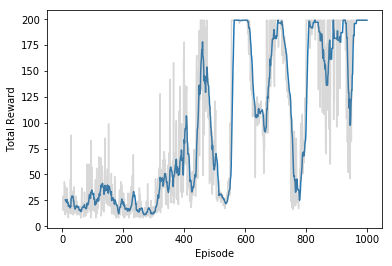

In [33]:
eps, rews = np.array(rewards_list).T
smoothed_rews = running_mean(rews, 10)
plt.plot(eps[-len(smoothed_rews):], smoothed_rews)
plt.plot(eps, rews, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total Reward')

### Testing
We can watch our trained model play Cart-Pole!

In [39]:
test_episodes = 10
test_max_steps = 400
env.reset()
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    for episode in range(1, test_episodes):
        current_step = 0
        while current_step < test_max_steps:
            env.render()
            
            feed = {mainQN.inputs_: state.reshape((1, *state.shape))}
            Qs = sess.run(mainQN.output, feed_dict=feed)
            action = np.argmax(Qs)
            
            next_state, reward, done, _ = env.step(action)
            
            if done:
                current_step = test_max_steps
                env.reset()
                state, reward, done, _ = env.step(env.action_space.sample())
            else:
                state = next_state
                current_step += 1
                

In [43]:
env.close()